In [24]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch

In [12]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

from berp.datasets import BerpDataset, NestedBerpDataset
from berp.generators import thresholded_recognition_simple as generator
from berp.generators.stimulus import RandomStimulusGenerator
from berp.models.reindexing_regression import ModelParameters

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Generate grouped dataset

In [17]:
synth_params = ModelParameters(
    lambda_=torch.tensor(1.0),
    confusion=generator.phoneme_confusion,
    threshold=torch.distributions.Beta(1.2, 1.2).sample(),

    # NB only used for generation, not in model
    a=torch.tensor(0.2),
    b=torch.tensor(0.1),
    coef=torch.tensor([-1]),
    sigma=torch.tensor(5.0),
)

sample_rate = 48
num_subjects = 8

In [21]:
stim = RandomStimulusGenerator(num_words=1000, num_phonemes=10, phoneme_voc_size=synth_params.confusion.shape[0],
                               word_surprisal_params=(2.0, 0.5))
ds_args = dict(
    response_type="gaussian",
    epoch_window=(0, 0.55), # TODO unused
    include_intercept=False,
    sample_rate=sample_rate)

# Pass a thunk to the dataset generator which returns the same thing every time
stim = stim(align_sample_rate=sample_rate)
stim_thunk = lambda: stim

datasets = []
for subject in range(num_subjects):
    ds_i = generator.sample_dataset(synth_params, stim_thunk, **ds_args)
    ds_i.name = f"synth/{subject}"
    datasets.append(ds_i)

In [51]:
nested_dataset = NestedBerpDataset(datasets, n_splits=20)

## Prepare plotting function

In [91]:
def plot_assignments(dataset: NestedBerpDataset, assignments: np.ndarray, ax=None):
    if len(assignments) != len(dataset.flat_idxs):
        raise ValueError()
        
    if ax is None:
        f, ax = plt.subplots()
        
    # Split into 2D array grouping by subdataset
    split_points = np.where((np.diff(dataset.flat_idxs[:, 0]) != 0))[0] + 1
    
    subdatasets = np.split(np.arange(len(nested_dataset)), split_points)
    subassignments = np.split(assignments, split_points)
    
    for i, (subdatasets_i, subassignments_i) in enumerate(zip(subdatasets, subassignments)):
        ax.scatter(
            subdatasets_i - subdatasets_i.min(),
            [i + 0.5] * len(subdatasets_i),
            c=subassignments_i,
            marker="_",
            lw=10,
            cmap=plt.cm.coolwarm,
            vmin=assignments.min(), vmax=assignments.max(),
        )
        
    ax.set(ylabel="Subject", xlabel="Time")

In [121]:
def plot_splitter(dataset: NestedBerpDataset, splitter, ax=None, **split_kwargs):
    """
    Plot test fold index for each data slice.
    """
    assignments = np.zeros(len(dataset), dtype=np.int32)
    
    for split, (train, test) in enumerate(splitter.split(dataset, **split_kwargs)):
        assignments[test] = split
    
    print(assignments)
    plot_assignments(dataset, assignments, ax=ax)
    
def plot_splitter_draws(dataset: NestedBerpDataset, splitter, **split_kwargs):
    """
    Plot the actual train/test split for each draw from the splitter.
    """
    
    f, axs = plt.subplots(splitter.n_splits, figsize=(5, 20))
    
    for split, (ax, (train, test)) in enumerate(zip(axs, splitter.split(dataset, **split_kwargs))):
        assignments = np.zeros(len(dataset), dtype=np.int32)
        assignments[train] = 0
        assignments[test] = 1
        plot_assignments(dataset, assignments, ax=ax)

### Demo plot

In [111]:
from sklearn.model_selection import KFold, GroupKFold

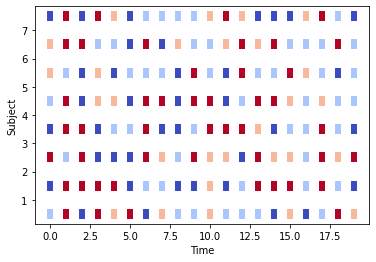

In [112]:
f, ax = plt.subplots()
assignments = np.random.randint(0, 4, size=len(nested_dataset))
plot_assignments(nested_dataset, assignments, ax=ax)

## Real plots

### KFold

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2]


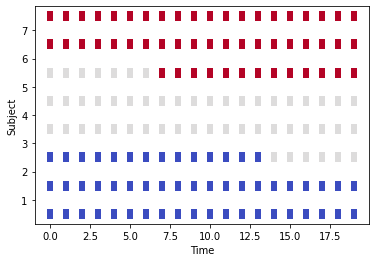

In [113]:
plot_splitter(nested_dataset, KFold(3))

### GroupKFold

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0]


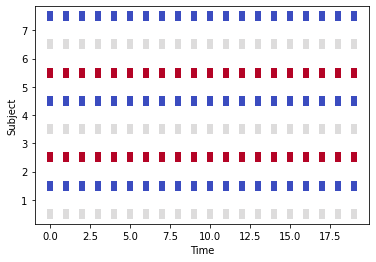

In [114]:
groups = [subject for subject, _, _ in nested_dataset.flat_idxs]
plot_splitter(nested_dataset, GroupKFold(3), groups=groups)

### GroupKFold by time

[3 2 3 0 1 2 3 0 1 2 3 0 1 2 3 0 1 2 1 0 3 2 3 0 1 2 3 0 1 2 3 0 1 2 3 0 1
 2 1 0 3 2 3 0 1 2 3 0 1 2 3 0 1 2 3 0 1 2 1 0 3 2 3 0 1 2 3 0 1 2 3 0 1 2
 3 0 1 2 1 0 3 2 3 0 1 2 3 0 1 2 3 0 1 2 3 0 1 2 1 0 3 2 3 0 1 2 3 0 1 2 3
 0 1 2 3 0 1 2 1 0 3 2 3 0 1 2 3 0 1 2 3 0 1 2 3 0 1 2 1 0 3 2 3 0 1 2 3 0
 1 2 3 0 1 2 3 0 1 2 1 0]


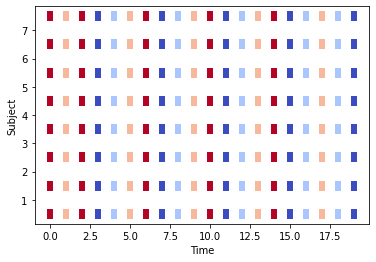

In [117]:
groups = [start_idx for subject, start_idx, _ in nested_dataset.flat_idxs]
plot_splitter(nested_dataset, GroupKFold(4), groups=groups)

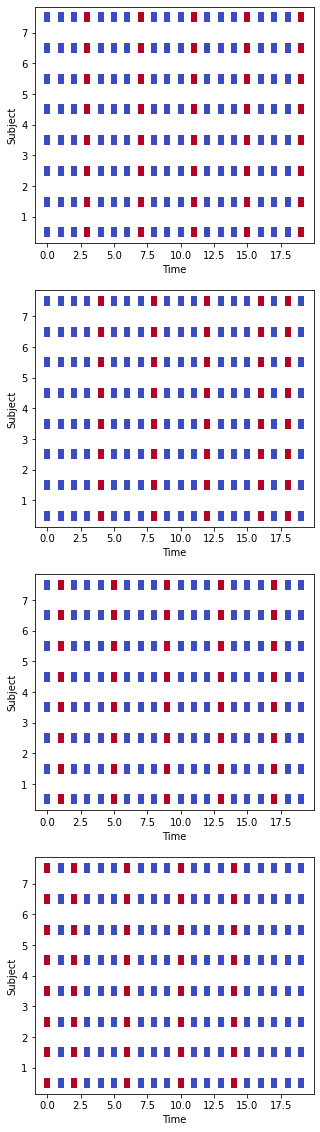

In [122]:
groups = [start_idx for subject, start_idx, _ in nested_dataset.flat_idxs]
plot_splitter_draws(nested_dataset, GroupKFold(4), groups=groups)